## UMAP & hdbscan

This was an attemp to understand the inner structure of both Top2Vec and BerTopic.


In [ ]:
#uncomment this is if you did not install bertopic model already
#!pip install bertopic

In [1]:
# from bertopic import BERTopic
import numpy as np 
import pandas as pd 
import os
import time

In [22]:
%%time
abstracts=pd.read_excel('AbstractsCleanUpdatednew.xlsx', nrows=15000, usecols=['Publication Date','Title','Abstract'])
# abstracts=pd.read_csv("abstract_list.csv", nrows=20000)

# titles=titles['Title'].to_list()
title = abstracts['Title'].to_list()



CPU times: user 33.5 s, sys: 1.09 s, total: 34.6 s
Wall time: 35.4 s


In [23]:
%%time
from sentence_transformers import SentenceTransformer
model = SentenceTransformer('distilbert-base-nli-mean-tokens')
embeddings = model.encode(title, show_progress_bar=True)


CPU times: user 13min 45s, sys: 33.9 s, total: 14min 18s
Wall time: 13min 56s


In [24]:
%%time
import umap
umap_embeddings = umap.UMAP(n_neighbors=20, 
                            n_components=2, 
                            metric='cosine').fit_transform(embeddings)

CPU times: user 27.1 s, sys: 1.07 s, total: 28.2 s
Wall time: 13.9 s


In [26]:
%%time
import hdbscan
cluster = hdbscan.HDBSCAN(min_cluster_size=20,
                          metric='euclidean',                      
                          cluster_selection_method='eom').fit(umap_embeddings)


CPU times: user 467 ms, sys: 11.8 ms, total: 479 ms
Wall time: 481 ms


CPU times: user 68.6 ms, sys: 58.1 ms, total: 127 ms
Wall time: 194 ms


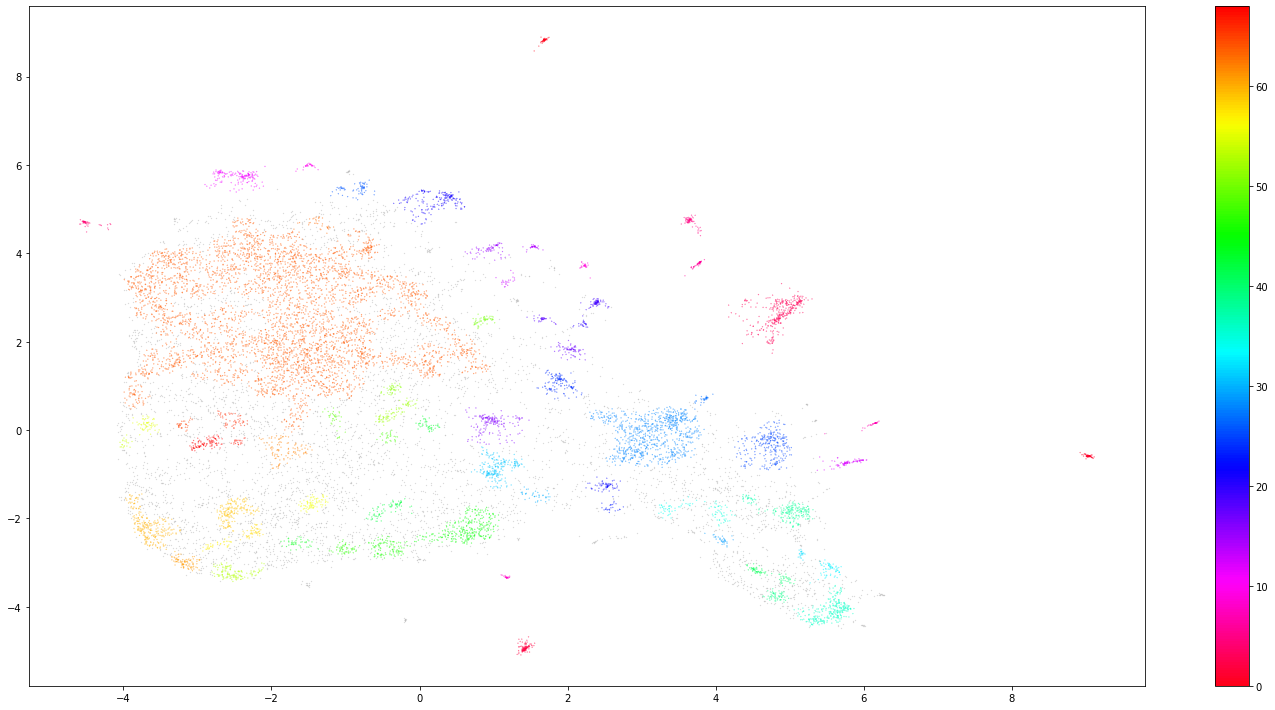

In [27]:
%%time
import matplotlib.pyplot as plt

# Prepare data
# umap_data = umap.UMAP(n_neighbors=50, n_components=2, min_dist=0.0, metric='cosine').fit_transform(embeddings)
result = pd.DataFrame(umap_embeddings, columns=['x', 'y'])
result['labels'] = cluster.labels_

# Visualize clusters
fig, ax = plt.subplots(figsize=(25, 12.5))
outliers = result.loc[result.labels == -1, :]
clustered = result.loc[result.labels != -1, :]
plt.scatter(outliers.x, outliers.y, color='#BDBDBD', s=0.05)
plt.scatter(clustered.x, clustered.y, c=clustered.labels, s=0.05, cmap='hsv_r')
plt.colorbar()

In [12]:
docs_df = pd.DataFrame(title, columns=["Doc"])
docs_df['Topic'] = cluster.labels_
docs_df['Doc_ID'] = range(len(docs_df))
docs_per_topic = docs_df.groupby(['Topic'], as_index = False).agg({'Doc': ' '.join})


In [14]:
docs_per_topic

,Topic,Doc
0,-1,"Effectiveness of Interferon Beta 1a, compared ..."
1,0,"Test, Trace, and Isolate: COVID-19 and the Can..."
2,1,Conversations and Medical News Frames on Twitt...
3,2,Critical care demand and intensive care supply...
4,3,Modelling and Predicting the Spatio-Temporal S...
5,4,Simulation-based Estimation of the Spread of C...
6,5,Aspectos Psicocomportamentais durante a Pandem...
7,6,Impacts of Early Interventions on the Age-Spec...
8,7,Seroprevalence against COVID-19 and follow-up ...
9,8,Projecting the Spread of COVID19 for Germany I...


In [12]:
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer

def c_tf_idf(documents, m, ngram_range=(1, 1)):
    count = CountVectorizer(ngram_range=ngram_range, stop_words="english").fit(documents)
    t = count.transform(documents).toarray()
    w = t.sum(axis=1)
    tf = np.divide(t.T, w)
    sum_t = t.sum(axis=0)
    idf = np.log(np.divide(m, sum_t)).reshape(-1, 1)
    tf_idf = np.multiply(tf, idf)

    return tf_idf, count
  
tf_idf, count = c_tf_idf(docs_per_topic.Doc.values, m=len(titles))


In [26]:
count

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                lowercase=True, max_df=1.0, max_features=None, min_df=1,
                ngram_range=(1, 1), preprocessor=None, stop_words='english',
                strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, vocabulary=None)

In [21]:
def extract_top_n_words_per_topic(tf_idf, count, docs_per_topic, n=20):
    words = count.get_feature_names()
    labels = list(docs_per_topic.Topic)
    tf_idf_transposed = tf_idf.T
    indices = tf_idf_transposed.argsort()[:, -n:]
    top_n_words = {label: [(words[j], tf_idf_transposed[i][j]) for j in indices[i]][::-1] for i, label in enumerate(labels)}
    return top_n_words

def extract_topic_sizes(df):
    topic_sizes = (df.groupby(['Topic'])
                     .Doc
                     .count()
                     .reset_index()
                     .rename({"Topic": "Topic", "Doc": "Size"}, axis='columns')
                     .sort_values("Size", ascending=False))
    return topic_sizes

top_n_words = extract_top_n_words_per_topic(tf_idf, count, docs_per_topic, n=20)
topic_sizes = extract_topic_sizes(docs_df); topic_sizes.head(10)

,Topic,Size
0,-1,11222
85,84,736
9,8,366
54,53,321
87,86,295
52,51,287
59,58,260
65,64,232
7,6,192
35,34,163


In [23]:
top_n_words[85][:15]

[('antibodies', 0.22678223430451772),
 ('cov', 0.157143743416485),
 ('antibody', 0.15283823359680523),
 ('sars', 0.15109799994161355),
 ('neutralizing', 0.11921886649828109),
 ('human', 0.08471912603540047),
 ('spike', 0.06702181038789862),
 ('epitopes', 0.060191839815779774),
 ('igg', 0.0533531544547294),
 ('potent', 0.04892888203060933),
 ('specific', 0.04842771284534982),
 ('cell', 0.04703824669540178),
 ('monoclonal', 0.04688043730471726),
 ('response', 0.04527015641263125),
 ('protein', 0.044331065013803336)]

In [33]:
from sklearn.metrics.pairwise import cosine_similarity
for i in range(40):
    # Calculate cosine similarity
    similarities = cosine_similarity(tf_idf.T)
    np.fill_diagonal(similarities, 0)

    # Extract label to merge into and from where
    topic_sizes = docs_df.groupby(['Topic']).count().sort_values("Doc", ascending=False).reset_index()
    topic_to_merge = topic_sizes.iloc[-1].Topic
    topic_to_merge_into = np.argmax(similarities[topic_to_merge + 1]) - 1

    # Adjust topics
    docs_df.loc[docs_df.Topic == topic_to_merge, "Topic"] = topic_to_merge_into
    old_topics = docs_df.sort_values("Topic").Topic.unique()
    map_topics = {old_topic: index - 1 for index, old_topic in enumerate(old_topics)}
    docs_df.Topic = docs_df.Topic.map(map_topics)
    docs_per_topic = docs_df.groupby(['Topic'], as_index = False).agg({'Doc': ' '.join})

    # Calculate new topic words
    m = len(titles)
    tf_idf, count = c_tf_idf(docs_per_topic.Doc.values, m)
    top_n_words = extract_top_n_words_per_topic(tf_idf, count, docs_per_topic, n=20)

topic_sizes = extract_topic_sizes(docs_df); topic_sizes.head(10)

,Topic,Size
0,-1,11646
43,42,768
8,7,366
45,44,336
27,26,321
25,24,287
31,30,260
33,32,232
57,56,211
6,5,192


In [34]:
topic_sizes

,Topic,Size
0,-1,11646
43,42,768
8,7,366
45,44,336
27,26,321
...,...,...
13,12,54
1,0,53
53,52,53
4,3,52


In [35]:
top_n_words


{-1: [('sars', 0.030582912865308263),
  ('cov', 0.030098015382653394),
  ('patients', 0.02685139961141464),
  ('pandemic', 0.02575469929586382),
  ('19', 0.025096561092596066),
  ('covid', 0.02497262031196933),
  ('infection', 0.01938648610674077),
  ('study', 0.018025644843689296),
  ('coronavirus', 0.01720039562493062),
  ('analysis', 0.016649575864929943),
  ('disease', 0.015498966190664265),
  ('clinical', 0.01533344376284678),
  ('health', 0.014084461602233173),
  ('case', 0.013985014790004599),
  ('review', 0.013251923767916663),
  ('severe', 0.01282771940430138),
  ('risk', 0.012677903875573365),
  ('impact', 0.012372991278769133),
  ('care', 0.012303255230424482),
  ('based', 0.011562523369384918)],
 0: [('canada', 0.32912254726846496),
  ('canadian', 0.20299117941034484),
  ('ontario', 0.17771710480489336),
  ('toronto', 0.051676321745183974),
  ('society', 0.0508184993820705),
  ('guidance', 0.04698042477903612),
  ('care', 0.041048452453193114),
  ('pandemic', 0.040491728499